In [1]:
import sys
import numpy as np
import scipy
import scipy.io
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import mintegpy as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py as h5
import os
import torch
sys.path.append('/Users/juanesteban')
import PINNFramework as pf
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D 

modified
Was not able to import Horovod. Thus Horovod support is not enabled


### Define the Simulation Parameters

In [25]:
e_l = 0 # n-th eigenvalue of analytical solution
#Parameters for
DIM = 3
DEG = 10
LP=2
POINTKIND = 'gauss_leg'#'leja'
USEDATA = False
#Doamin Bounds
lb = np.array([-2.0, -2.0, 0.0])
ub = np.array([2.0, 2.0, 0])
# Number of Epoch
n_epoch = 500
#Create 2-D Dataset from the analytical solution

#### Dataset Generating fuctions

In [26]:
#Create 2-D Dataset from the analytical solution
def Herm_pol(n):
    p =  sp.Symbol('p')
    d_0 = sp.diff(sp.exp(-p**2),p)
    d_n =d_0
    for i in range(n):
        d_n = sp.diff(d_n,p)
    Hn = sp.lambdify(p,sp.simplify((-1)**n*d_n*sp.exp(p**2)))
    return Hn
def Psi (x,y,t,f):
    Hn= Herm_pol(e_l)
    return np.exp(-1j*0)*1/(2**e_l*scipy.math.factorial(e_l))*(np.pi**(-1/4))*np.exp(-(x**2+y**2)/2)*Hn(x)*Hn(y)

def eigenvalue (ev):
    a =  sp.Symbol('a')
    b =  sp.Symbol('b')
    c =  sp.Symbol('c')
    d_0a = sp.diff(sp.exp(-a**2),a)
    d_na =d_0a
    for i in range(ev):
        d_na = sp.diff(d_na,a)
    Hna= sp.simplify((-1)**ev*d_na*sp.exp(a**2))
    d_0b = sp.diff(sp.exp(-b**2),b)
    d_nb =d_0b
    for i in range(ev):
        d_nb =sp.diff(d_nb,b)
    Hnb = sp.simplify((-1)**ev*d_nb*sp.exp(b**2))
    Psi = (1/(2**e_l*sp.factorial(ev))*(np.pi**(-1/4))*
     sp.exp(-(a**2+b**2)/2)*Hna*Hnb)
    return int(sp.simplify((-1/2*(sp.diff(Psi,a,a)+sp.diff(Psi,b,b))+
                            1/2*(a**2+b**2)*Psi)/Psi))
lam = eigenvalue(e_l)

def set_gen_1d(POLYDEG,n_bdy):
    unscaled_pts = np.polynomial.legendre.leggauss(POLYDEG)
    scaled_pts = []
    weights = []
    for i in range(3):
        if (n_bdy[1][i]-n_bdy[0][i])/2 == 0:
            scaled_pts.append([n_bdy[1][i]])
            weights.append([1])
        else:
            m = (n_bdy[1][i]-n_bdy[0][i])/2
            b = (n_bdy[0][i]+n_bdy[1][i])/2
            scaled_pts.append(unscaled_pts[0]*m+b)
            weights.append(unscaled_pts[1]*m)
    Grid = np.array([[[[scaled_pts[0][i],scaled_pts[1][j],scaled_pts[2][k]]
                   for i in range(len(scaled_pts[0]))]for j in range(len(scaled_pts[1]))]
                 for k in range(len(scaled_pts[2]))]).reshape(len(scaled_pts[0])
                                                              *len(scaled_pts[1])*
                                                              len(scaled_pts[2]),3)
    Weights = np.array([[[weights[0][i]*weights[1][j]*weights[2][k]
                   for i in range(len(weights[0]))]for j in range(len(weights[1]))]
                 for k in range(len(weights[2]))]).reshape(len(weights[0])
                                                              *len(weights[1])*
                                                              len(weights[2]))
    return Grid, Weights

def MSE_set(n_bdy,  nb, x_dim=1, y_dim=1, nsteps=1, dt=0.1):
    xl = np.array(list(zip(np.linspace(n_bdy[0][0], n_bdy[0][0], x_dim),
                           np.linspace(n_bdy[0][1], n_bdy[1][1], y_dim))))
    xr = np.array(list(zip(np.linspace(n_bdy[1][0], n_bdy[1][0], x_dim),
                           np.linspace(n_bdy[1][1], n_bdy[1][1], y_dim))))
    yu = np.array(list(zip(np.linspace(n_bdy[0][0], n_bdy[1][0], x_dim),
                           np.linspace(n_bdy[1][1], n_bdy[1][1], y_dim))))
    ylw = np.array(list(zip(np.linspace(n_bdy[0][0], n_bdy[1][0], x_dim),
                            np.linspace(n_bdy[0][1], n_bdy[0][1], y_dim))))
    x_b = np.array(np.concatenate([xl, xr, yu, ylw], axis=0))
    T = np.linspace(0, nsteps * dt, nsteps)
    xyt = np.array([[[x_b[i][0], x_b[i][0], T[k]] for i in range(len(x_b))] for k in range(len(T))])
    Bdy_coor = xyt.reshape(xyt.shape[0] * xyt.shape[1], xyt.shape[2])
    index_bdy = np.random.choice(len(Bdy_coor), nb, replace=False)
    return Bdy_coor[index_bdy]

class BoundaryConditionDataset(Dataset):

    def __init__(self, boundary_set) -> object:
        """_bdy, x_dim, y_dim, nsteps, d
        Constructor of the Boundary condition dataset, with x_bdy an array with the
        lower and uper bound in the x direction and respectively y_bdy. Only for square domain.
        """
        self.Bdy_training = boundary_set
    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.Bdy_training).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1
class InitialConditionDataset(Dataset):

    def __init__(self,initial_set, norm = 'L2', n_bdy=[], x_dim=1, y_dim=1, nx =1 ):
        """
        Constructor of the boundary condition dataset
        Args:
          n0 (int)
        """
        super(type(self)).__init__()
        if norm =='Mse' or norm== 'Wass':
            x_0 = np.linspace(n_bdy[0][0], n_bdy[1][0], x_dim)
            y_0 = np.linspace(n_bdy[0][1], n_bdy[1][1], y_dim)
            X, Y = np.meshgrid(x_0, y_0)
            X_0 = X.reshape(-1)
            Y_0 = Y.reshape(-1)
            idx_x = np.random.choice(len(X_0), nx, replace=False)
            self.x = np.array([X_0[idx_x]]).T
            self.y = np.array([Y_0[idx_x]]).T
            sol = Psi(self.x, self.y, 0, 1)  # Psi(x,y,t=0,f)
            self.u = sol.real
            self.v = sol.imag
            self.t = np.array([np.zeros(len(self.x))]).T
        elif norm == 'Quad':
            X = np.array(initial_set[0])
            Y = np.array(initial_set[1])
            #X, Y = np.meshgrid(x_0, y_0)
            self.x = np.array([X.reshape(-1)]).T
            self.y = np.array([Y.reshape(-1)]).T
            sol = Psi(self.x,self.y,0,1)
            self.u = sol.real
            self.v = sol.imag
            self.t = np.array([np.zeros(len(self.x))]).T
        else:
            raise ValueError('Norm not defined')
    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self,idx):
        x = np.concatenate([self.x,self.y,self.t],axis=1)
        y = np.concatenate([self.u,self.v],axis=1)
        return Tensor(x).float(), Tensor(y).float()

class PDEDataset(Dataset):
    def __init__(self, residual_set):
        self.xf = np.array(residual_set).T
    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1


#### Definition and creation of the different datasets and losses

In [27]:
if __name__ == "__main__":
    # Domain bounds
    #Create Datasets for the different Losses
    def schroedinger1d(x, u):
        omega = 1
        pred = u
        u = pred[:, 0]
        v = pred[:, 1]
        grads = ones(u.shape, device=pred.device)  # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        u_t = grad_u[:, 2]
        v_x = grad_v[:, 0]
        v_y = grad_v[:, 1]
        v_t = grad_v[:, 2]
        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        u_yy = grad_u_x[:, 1]
        v_xx = grad_v_x[:, 0]
        v_yy = grad_v_x[:, 1]
        f_r = -1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u - lam*u
        #print(torch.mean((-1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u)/u),torch.std((-1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u)/u))
        #f_u = -1 * u_t - 0.5 * v_xx - 0.5 * v_yy + omega * 0.5 * (x[:, 0] ** 2) * v + omega * 0.5 * (x[:, 1] ** 2) * v
        # fv is the imaginary part of the schrodinger equation
        #f_v = -1 * v_t + 0.5 * u_xx + 0.5 * u_yy - omega * 0.5 * (x[:, 0] ** 2) * u - omega * 0.5 * (x[:, 1] ** 2) * u
        return f_r#stack([f_u, f_v], 1)  # concatenate real part and imaginary part
    def res_left(x, u):
        omega = 1
        pred = u
        u = pred[:, 0]
        v = pred[:, 1]
        grads = ones(u.shape, device=pred.device)  # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        u_t = grad_u[:, 2]
        v_x = grad_v[:, 0]
        v_y = grad_v[:, 1]
        v_t = grad_v[:, 2]
        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        u_yy = grad_u_x[:, 1]
        v_xx = grad_v_x[:, 0]
        v_yy = grad_v_x[:, 1]
        f_left =  lam*u
        #f_right = -1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u
        #f_u = -1 * u_t - 0.5 * v_xx - 0.5 * v_yy + omega * 0.5 * (x[:, 0] ** 2) * v + omega * 0.5 * (x[:, 1] ** 2) * v
        # fv is the imaginary part of the schrodinger equation
        #f_v = -1 * v_t + 0.5 * u_xx + 0.5 * u_yy - omega * 0.5 * (x[:, 0] ** 2) * u - omega * 0.5 * (x[:, 1] ** 2) * u
        return f_left#stack([f_u, f_v], 1)  # concatenate real part and imaginary part
    def res_right(x, u):
        omega = 1
        pred = u
        u = pred[:, 0]
        v = pred[:, 1]
        grads = ones(u.shape, device=pred.device)  # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        u_t = grad_u[:, 2]
        v_x = grad_v[:, 0]
        v_y = grad_v[:, 1]
        v_t = grad_v[:, 2]
        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        u_yy = grad_u_x[:, 1]
        v_xx = grad_v_x[:, 0]
        v_yy = grad_v_x[:, 1]
        f_right = -1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u
        #f_u = -1 * u_t - 0.5 * v_xx - 0.5 * v_yy + omega * 0.5 * (x[:, 0] ** 2) * v + omega * 0.5 * (x[:, 1] ** 2) * v
        # fv is the imaginary part of the schrodinger equation
        #f_v = -1 * v_t + 0.5 * u_xx + 0.5 * u_yy - omega * 0.5 * (x[:, 0] ** 2) * u - omega * 0.5 * (x[:, 1] ** 2) * u
        return f_right#stack([f_u, f_v], 1)  # concatenate real part and imaginary part
    def hom_dir(x):
        P = Psi(x[:,0], x[:,1], x[:,2], 1)
        P_r = P.real
        P_im = P.imag
        return torch.stack((P_r,P_im),1)
    def residual_check(x):
        P = Psi(x[:, 0], x[:, 1], x[:, 2], 1)
        P_r = P.real
        return P_r
    def Dataset_loss (Norm, bounds , n_points, deg = 1):
        [lb, ub] = bounds
        residual_bdy = [[lb[0], lb[1], lb[2]], [ub[0], ub[1], ub[2]]]
        initial_bdy = [[lb[0], lb[1], lb[2]], [ub[0], ub[1], lb[2]]]
        boundary_bdy = [[[lb[0], lb[1], lb[2]], [lb[0], ub[1], ub[2]]], [[ub[0], lb[1], lb[2]], [ub[0], ub[1], ub[2]]],
                        [[lb[0], lb[1], lb[2]], [ub[0], lb[1], ub[2]]],
                        [[lb[0], ub[1], lb[2]], [ub[0], ub[1], ub[2]]]]
        if Norm == 'Mse' or Norm == 'Wass':
            boundary_set = np.concatenate([MSE_set(boundary_bdy[i], nb= n_points,
                                                       x_dim=1000, y_dim=1000, nsteps=1, dt=0.1) for i in range(4)], axis=0)
            residual_set = MSE_set(residual_bdy, nb= n_points, x_dim=1000, y_dim=1000, nsteps=1, dt=0.1).T
            initial_set = []
            Datasets = [[boundary_set, residual_set, initial_set],[[0],[0],[0]]]
        elif Norm == 'Quad':
            I_C_1d = set_gen_1d(deg, initial_bdy)
            initial_set = I_C_1d[0].T
            initial_weights = I_C_1d[1]
            boundary_set = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[0] for i in range(4)], axis=0)
            boundary_weights = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[1] for i in range(4)], axis=0)
            RS_1d = set_gen_1d(deg, residual_bdy)
            residual_set = RS_1d[0].T
            residual_weights = RS_1d[1]
            Datasets = [[boundary_set, residual_set, initial_set],[boundary_weights, residual_weights, initial_weights]]
        else:
            raise(ValueError('Loss not defined'))
        ## Crete Loss functions
        #Boundary term
        bc_dataset = BoundaryConditionDataset(Datasets[0][0])
        dirichlet_bc = pf.DirichletBC(func=hom_dir, dataset=bc_dataset, quad_weights=Datasets[1][0]  , name='Dirichlet BC', norm=Norm)
        # Residual Terms
        pde_dataset = PDEDataset(Datasets[0][1])
        pde_loss = pf.PDELoss(pde_dataset, schroedinger1d,func= residual_check,
                              func_left = res_left, func_right = res_right,
                              quad_weights=Datasets[1][1], norm=Norm)
        #Initial Condition Term
        ic_dataset = InitialConditionDataset(Datasets[0][2], norm=Norm, n_bdy=initial_bdy, x_dim=1000, y_dim=1000, nx=n_points)
        initial_condition = pf.InitialCondition(ic_dataset,  quad_weights=Datasets[1][2], norm=Norm)
        #test_loss = tl.My_Loss(ic_dataset,  quad_weights=Datasets[1][2], norm=Norm)
        return [dirichlet_bc, pde_loss, initial_condition], [bc_dataset, pde_dataset, ic_dataset], Datasets[1]

In [ ]:
# Call the datasets functions, losses and weights for the training and for the performance measure
[dirichlet_bc_2, pde_loss_2, initial_condition_2], [bc_dataset_2, pde_dataset_2, ic_dataset_2], [boundary_weights_2,
                                                                                     residual_weights_2,
                                                                                     initial_weights_2] = Dataset_loss('Quad', [lb, ub], 1, deg=DEG)
[dirichlet_bc, pde_loss, initial_condition], [bc_dataset, pde_dataset, ic_dataset], [boundary_weights,
                                                                                     residual_weights,
                                                                                     initial_weights] = Dataset_loss('Mse', [lb, ub], len(initial_weights_2), deg=1)
[dirichlet_bc_3, pde_loss_3, initial_condition_3], [bc_dataset_3, pde_dataset_3, ic_dataset_3], [boundary_weights_3,
                                                                                     residual_weights_3,
                                                                                     initial_weights_3] = Dataset_loss('Wass', [lb, ub], len(initial_weights_2), deg=1)
model_1 = pf.models.MLP(input_size=3, output_size=2, hidden_size=50, num_hidden=4, lb=lb, ub=ub)
model_2 = pf.models.MLP(input_size=3, output_size=2, hidden_size=50, num_hidden=4, lb=lb, ub=ub)
model_3 = pf.models.MLP(input_size=3, output_size=2, hidden_size=50, num_hidden=4, lb=lb, ub=ub)


performance_var = [initial_condition, [dirichlet_bc], pde_loss_3]

pinn_1 = pf.PINN(model_1, 3, 2, pde_loss,initial_condition, performance_var, [dirichlet_bc], use_gpu=False)
loss_1 = pinn_1.fit(n_epoch, 'Adam', 1e-3)
pinn_2 = pf.PINN(model_2, 3, 2, pde_loss_2, initial_condition, performance_var, [dirichlet_bc_2], use_gpu=False)
loss_2= pinn_2.fit(n_epoch, 'Adam', 1e-3)
pinn_3 = pf.PINN(model_3, 3, 2, pde_loss_3, initial_condition, performance_var, [dirichlet_bc_3], use_gpu=False)
loss_3 = pinn_3.fit(n_epoch, 'Adam', 1e-3)

Measure Loss tensor(0.1293, grad_fn=<AddBackward0>)
PINN Loss 0.13387051224708557 Epoch 0 from 500
Measure Loss tensor(0.1329, grad_fn=<AddBackward0>)
PINN Loss 0.16082122921943665 Epoch 1 from 500
Measure Loss tensor(0.0951, grad_fn=<AddBackward0>)
PINN Loss 0.11649970710277557 Epoch 2 from 500
Measure Loss tensor(0.6928, grad_fn=<AddBackward0>)
PINN Loss 0.07734305411577225 Epoch 3 from 500
Measure Loss tensor(0.2098, grad_fn=<AddBackward0>)
PINN Loss 0.10581231862306595 Epoch 4 from 500
Measure Loss tensor(0.1604, grad_fn=<AddBackward0>)
PINN Loss 0.11389084160327911 Epoch 5 from 500
Measure Loss tensor(0.3685, grad_fn=<AddBackward0>)
PINN Loss 0.08874443918466568 Epoch 6 from 500
Measure Loss tensor(0.5623, grad_fn=<AddBackward0>)
PINN Loss 0.07418115437030792 Epoch 7 from 500
Measure Loss tensor(0.1675, grad_fn=<AddBackward0>)
PINN Loss 0.08382809907197952 Epoch 8 from 500
Measure Loss tensor(0.1227, grad_fn=<AddBackward0>)
PINN Loss 0.09408397972583771 Epoch 9 from 500
Measure Lo

Measure Loss tensor(0.1910, grad_fn=<AddBackward0>)
PINN Loss 0.0676625594496727 Epoch 83 from 500
Measure Loss tensor(0.1915, grad_fn=<AddBackward0>)
PINN Loss 0.0676548108458519 Epoch 84 from 500
Measure Loss tensor(0.1917, grad_fn=<AddBackward0>)
PINN Loss 0.06765082478523254 Epoch 85 from 500
Measure Loss tensor(0.1915, grad_fn=<AddBackward0>)
PINN Loss 0.06763836741447449 Epoch 86 from 500
Measure Loss tensor(0.1912, grad_fn=<AddBackward0>)
PINN Loss 0.06762343645095825 Epoch 87 from 500
Measure Loss tensor(0.1911, grad_fn=<AddBackward0>)
PINN Loss 0.06761522591114044 Epoch 88 from 500
Measure Loss tensor(0.1914, grad_fn=<AddBackward0>)
PINN Loss 0.06760822236537933 Epoch 89 from 500
Measure Loss tensor(0.1921, grad_fn=<AddBackward0>)
PINN Loss 0.06759566813707352 Epoch 90 from 500
Measure Loss tensor(0.1930, grad_fn=<AddBackward0>)
PINN Loss 0.06758251786231995 Epoch 91 from 500
Measure Loss tensor(0.1936, grad_fn=<AddBackward0>)
PINN Loss 0.06757339835166931 Epoch 92 from 500
Me

Measure Loss tensor(0.1203, grad_fn=<AddBackward0>)
PINN Loss 0.0638786107301712 Epoch 165 from 500
Measure Loss tensor(0.1162, grad_fn=<AddBackward0>)
PINN Loss 0.0636444240808487 Epoch 166 from 500
Measure Loss tensor(0.1119, grad_fn=<AddBackward0>)
PINN Loss 0.06339088827371597 Epoch 167 from 500
Measure Loss tensor(0.1073, grad_fn=<AddBackward0>)
PINN Loss 0.06311632692813873 Epoch 168 from 500
Measure Loss tensor(0.1027, grad_fn=<AddBackward0>)
PINN Loss 0.0628189966082573 Epoch 169 from 500
Measure Loss tensor(0.0983, grad_fn=<AddBackward0>)
PINN Loss 0.062497057020664215 Epoch 170 from 500
Measure Loss tensor(0.0939, grad_fn=<AddBackward0>)
PINN Loss 0.06214867904782295 Epoch 171 from 500
Measure Loss tensor(0.0896, grad_fn=<AddBackward0>)
PINN Loss 0.06177205964922905 Epoch 172 from 500
Measure Loss tensor(0.0855, grad_fn=<AddBackward0>)
PINN Loss 0.06136544048786163 Epoch 173 from 500
Measure Loss tensor(0.0830, grad_fn=<AddBackward0>)
PINN Loss 0.06092716008424759 Epoch 174 f

Measure Loss tensor(0.0167, grad_fn=<AddBackward0>)
PINN Loss 0.02937573567032814 Epoch 246 from 500
Measure Loss tensor(0.0164, grad_fn=<AddBackward0>)
PINN Loss 0.029000749811530113 Epoch 247 from 500
Measure Loss tensor(0.0159, grad_fn=<AddBackward0>)
PINN Loss 0.02877487987279892 Epoch 248 from 500
Measure Loss tensor(0.0161, grad_fn=<AddBackward0>)
PINN Loss 0.02889164164662361 Epoch 249 from 500
Measure Loss tensor(0.0155, grad_fn=<AddBackward0>)
PINN Loss 0.02835896424949169 Epoch 250 from 500
Measure Loss tensor(0.0163, grad_fn=<AddBackward0>)
PINN Loss 0.028623754158616066 Epoch 251 from 500
Measure Loss tensor(0.0157, grad_fn=<AddBackward0>)
PINN Loss 0.028129849582910538 Epoch 252 from 500
Measure Loss tensor(0.0159, grad_fn=<AddBackward0>)
PINN Loss 0.02819707617163658 Epoch 253 from 500
Measure Loss tensor(0.0158, grad_fn=<AddBackward0>)
PINN Loss 0.027969960123300552 Epoch 254 from 500
Measure Loss tensor(0.0163, grad_fn=<AddBackward0>)
PINN Loss 0.027812378481030464 Epoc

Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.016352301463484764 Epoch 327 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.016213152557611465 Epoch 328 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.016080627217888832 Epoch 329 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.015957606956362724 Epoch 330 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.01585998199880123 Epoch 331 from 500
Measure Loss tensor(0.0149, grad_fn=<AddBackward0>)
PINN Loss 0.015858082100749016 Epoch 332 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.016298584640026093 Epoch 333 from 500
Measure Loss tensor(0.0182, grad_fn=<AddBackward0>)
PINN Loss 0.018830519169569016 Epoch 334 from 500
Measure Loss tensor(0.0240, grad_fn=<AddBackward0>)
PINN Loss 0.0267952810972929 Epoch 335 from 500
Measure Loss tensor(0.0635, grad_fn=<AddBackward0>)
PINN Loss 0.03650885075330734 Epo

Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.009570170193910599 Epoch 408 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.009498277679085732 Epoch 409 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.009413096122443676 Epoch 410 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.009337447583675385 Epoch 411 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.00926091056317091 Epoch 412 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.009179779328405857 Epoch 413 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.009105518460273743 Epoch 414 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.009028419852256775 Epoch 415 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.00894958060234785 Epoch 416 from 500
Measure Loss tensor(0.0150, grad_fn=<AddBackward0>)
PINN Loss 0.008877075277268887 E

Measure Loss tensor(0.0155, grad_fn=<AddBackward0>)
PINN Loss 0.00459686852991581 Epoch 489 from 500
Measure Loss tensor(0.0155, grad_fn=<AddBackward0>)
PINN Loss 0.004553608596324921 Epoch 490 from 500
Measure Loss tensor(0.0155, grad_fn=<AddBackward0>)
PINN Loss 0.004510804079473019 Epoch 491 from 500
Measure Loss tensor(0.0155, grad_fn=<AddBackward0>)
PINN Loss 0.004468441940844059 Epoch 492 from 500
Measure Loss tensor(0.0156, grad_fn=<AddBackward0>)
PINN Loss 0.004426533356308937 Epoch 493 from 500
Measure Loss tensor(0.0156, grad_fn=<AddBackward0>)
PINN Loss 0.004385071806609631 Epoch 494 from 500
Measure Loss tensor(0.0156, grad_fn=<AddBackward0>)
PINN Loss 0.004344068467617035 Epoch 495 from 500
Measure Loss tensor(0.0156, grad_fn=<AddBackward0>)
PINN Loss 0.004303512629121542 Epoch 496 from 500
Measure Loss tensor(0.0156, grad_fn=<AddBackward0>)
PINN Loss 0.004263410344719887 Epoch 497 from 500
Measure Loss tensor(0.0156, grad_fn=<AddBackward0>)
PINN Loss 0.0042237574234604836

Measure Loss tensor(0.0898, grad_fn=<AddBackward0>)
PINN Loss 1.4597972631454468 Epoch 72 from 500
Measure Loss tensor(0.0877, grad_fn=<AddBackward0>)
PINN Loss 1.4599268436431885 Epoch 73 from 500
Measure Loss tensor(0.0931, grad_fn=<AddBackward0>)
PINN Loss 1.458240270614624 Epoch 74 from 500
Measure Loss tensor(0.0955, grad_fn=<AddBackward0>)
PINN Loss 1.4579174518585205 Epoch 75 from 500
Measure Loss tensor(0.0921, grad_fn=<AddBackward0>)
PINN Loss 1.456974983215332 Epoch 76 from 500
Measure Loss tensor(0.0896, grad_fn=<AddBackward0>)
PINN Loss 1.4559601545333862 Epoch 77 from 500
Measure Loss tensor(0.0891, grad_fn=<AddBackward0>)
PINN Loss 1.4553242921829224 Epoch 78 from 500
Measure Loss tensor(0.0887, grad_fn=<AddBackward0>)
PINN Loss 1.4545624256134033 Epoch 79 from 500
Measure Loss tensor(0.0918, grad_fn=<AddBackward0>)
PINN Loss 1.4534785747528076 Epoch 80 from 500
Measure Loss tensor(0.0931, grad_fn=<AddBackward0>)
PINN Loss 1.4533191919326782 Epoch 81 from 500
Measure Loss

Measure Loss tensor(0.0599, grad_fn=<AddBackward0>)
PINN Loss 1.3435747623443604 Epoch 155 from 500
Measure Loss tensor(0.0596, grad_fn=<AddBackward0>)
PINN Loss 1.3409751653671265 Epoch 156 from 500
Measure Loss tensor(0.0594, grad_fn=<AddBackward0>)
PINN Loss 1.3383512496948242 Epoch 157 from 500
Measure Loss tensor(0.0592, grad_fn=<AddBackward0>)
PINN Loss 1.3357040882110596 Epoch 158 from 500
Measure Loss tensor(0.0589, grad_fn=<AddBackward0>)
PINN Loss 1.333035945892334 Epoch 159 from 500
Measure Loss tensor(0.0586, grad_fn=<AddBackward0>)
PINN Loss 1.3303499221801758 Epoch 160 from 500
Measure Loss tensor(0.0584, grad_fn=<AddBackward0>)
PINN Loss 1.3276475667953491 Epoch 161 from 500
Measure Loss tensor(0.0582, grad_fn=<AddBackward0>)
PINN Loss 1.32493257522583 Epoch 162 from 500
Measure Loss tensor(0.0580, grad_fn=<AddBackward0>)
PINN Loss 1.3222074508666992 Epoch 163 from 500
Measure Loss tensor(0.0578, grad_fn=<AddBackward0>)
PINN Loss 1.3194758892059326 Epoch 164 from 500
Mea

Measure Loss tensor(0.0592, grad_fn=<AddBackward0>)
PINN Loss 1.2176541090011597 Epoch 238 from 500
Measure Loss tensor(0.0592, grad_fn=<AddBackward0>)
PINN Loss 1.2171142101287842 Epoch 239 from 500
Measure Loss tensor(0.0592, grad_fn=<AddBackward0>)
PINN Loss 1.2165791988372803 Epoch 240 from 500
Measure Loss tensor(0.0592, grad_fn=<AddBackward0>)
PINN Loss 1.2160496711730957 Epoch 241 from 500
Measure Loss tensor(0.0593, grad_fn=<AddBackward0>)
PINN Loss 1.215524673461914 Epoch 242 from 500
Measure Loss tensor(0.0593, grad_fn=<AddBackward0>)
PINN Loss 1.2150046825408936 Epoch 243 from 500
Measure Loss tensor(0.0593, grad_fn=<AddBackward0>)
PINN Loss 1.2144888639450073 Epoch 244 from 500
Measure Loss tensor(0.0593, grad_fn=<AddBackward0>)
PINN Loss 1.2139776945114136 Epoch 245 from 500
Measure Loss tensor(0.0591, grad_fn=<AddBackward0>)
PINN Loss 1.2134701013565063 Epoch 246 from 500
Measure Loss tensor(0.0591, grad_fn=<AddBackward0>)
PINN Loss 1.2129669189453125 Epoch 247 from 500
M

Measure Loss tensor(0.0655, grad_fn=<AddBackward0>)
PINN Loss 1.1857097148895264 Epoch 321 from 500
Measure Loss tensor(0.0573, grad_fn=<AddBackward0>)
PINN Loss 1.1856520175933838 Epoch 322 from 500
Measure Loss tensor(0.0642, grad_fn=<AddBackward0>)
PINN Loss 1.1845251321792603 Epoch 323 from 500
Measure Loss tensor(0.0619, grad_fn=<AddBackward0>)
PINN Loss 1.1837284564971924 Epoch 324 from 500
Measure Loss tensor(0.0593, grad_fn=<AddBackward0>)
PINN Loss 1.1838740110397339 Epoch 325 from 500
Measure Loss tensor(0.0656, grad_fn=<AddBackward0>)
PINN Loss 1.184028148651123 Epoch 326 from 500
Measure Loss tensor(0.0589, grad_fn=<AddBackward0>)
PINN Loss 1.1834291219711304 Epoch 327 from 500
Measure Loss tensor(0.0632, grad_fn=<AddBackward0>)
PINN Loss 1.1825687885284424 Epoch 328 from 500
Measure Loss tensor(0.0629, grad_fn=<AddBackward0>)
PINN Loss 1.1821846961975098 Epoch 329 from 500
Measure Loss tensor(0.0596, grad_fn=<AddBackward0>)
PINN Loss 1.1822338104248047 Epoch 330 from 500
M

Measure Loss tensor(0.0600, grad_fn=<AddBackward0>)
PINN Loss 1.1608814001083374 Epoch 404 from 500
Measure Loss tensor(0.0689, grad_fn=<AddBackward0>)
PINN Loss 1.1613881587982178 Epoch 405 from 500
Measure Loss tensor(0.0574, grad_fn=<AddBackward0>)
PINN Loss 1.1623713970184326 Epoch 406 from 500
Measure Loss tensor(0.0722, grad_fn=<AddBackward0>)
PINN Loss 1.1642346382141113 Epoch 407 from 500
Measure Loss tensor(0.0531, grad_fn=<AddBackward0>)
PINN Loss 1.167157530784607 Epoch 408 from 500
Measure Loss tensor(0.0772, grad_fn=<AddBackward0>)
PINN Loss 1.1716244220733643 Epoch 409 from 500
Measure Loss tensor(0.0484, grad_fn=<AddBackward0>)
PINN Loss 1.176005244255066 Epoch 410 from 500
Measure Loss tensor(0.0806, grad_fn=<AddBackward0>)
PINN Loss 1.1790937185287476 Epoch 411 from 500
Measure Loss tensor(0.0479, grad_fn=<AddBackward0>)
PINN Loss 1.176628589630127 Epoch 412 from 500
Measure Loss tensor(0.0769, grad_fn=<AddBackward0>)
PINN Loss 1.1706751585006714 Epoch 413 from 500
Mea

Measure Loss tensor(0.0710, grad_fn=<AddBackward0>)
PINN Loss 1.1355797052383423 Epoch 487 from 500
Measure Loss tensor(0.0554, grad_fn=<AddBackward0>)
PINN Loss 1.137939453125 Epoch 488 from 500
Measure Loss tensor(0.0761, grad_fn=<AddBackward0>)
PINN Loss 1.1420106887817383 Epoch 489 from 500
Measure Loss tensor(0.0496, grad_fn=<AddBackward0>)
PINN Loss 1.1473474502563477 Epoch 490 from 500
Measure Loss tensor(0.0809, grad_fn=<AddBackward0>)
PINN Loss 1.152435302734375 Epoch 491 from 500
Measure Loss tensor(0.0470, grad_fn=<AddBackward0>)
PINN Loss 1.1528611183166504 Epoch 492 from 500
Measure Loss tensor(0.0790, grad_fn=<AddBackward0>)
PINN Loss 1.147756576538086 Epoch 493 from 500
Measure Loss tensor(0.0526, grad_fn=<AddBackward0>)
PINN Loss 1.1393417119979858 Epoch 494 from 500
Measure Loss tensor(0.0702, grad_fn=<AddBackward0>)
PINN Loss 1.1323798894882202 Epoch 495 from 500
Measure Loss tensor(0.0621, grad_fn=<AddBackward0>)
PINN Loss 1.128822684288025 Epoch 496 from 500
Measure

Measure Loss tensor(0.3543, grad_fn=<AddBackward0>)
PINN Loss 0.5471138954162598 Epoch 70 from 500
Measure Loss tensor(0.3418, grad_fn=<AddBackward0>)
PINN Loss 0.5256980657577515 Epoch 71 from 500
Measure Loss tensor(0.3296, grad_fn=<AddBackward0>)
PINN Loss 0.5101585388183594 Epoch 72 from 500
Measure Loss tensor(0.3258, grad_fn=<AddBackward0>)
PINN Loss 0.5080578327178955 Epoch 73 from 500
Measure Loss tensor(0.3227, grad_fn=<AddBackward0>)
PINN Loss 0.5095789432525635 Epoch 74 from 500
Measure Loss tensor(0.3176, grad_fn=<AddBackward0>)
PINN Loss 0.5092893838882446 Epoch 75 from 500
Measure Loss tensor(0.3107, grad_fn=<AddBackward0>)
PINN Loss 0.5038996338844299 Epoch 76 from 500
Measure Loss tensor(0.3018, grad_fn=<AddBackward0>)
PINN Loss 0.4923868775367737 Epoch 77 from 500
Measure Loss tensor(0.2918, grad_fn=<AddBackward0>)
PINN Loss 0.47722381353378296 Epoch 78 from 500
Measure Loss tensor(0.2813, grad_fn=<AddBackward0>)
PINN Loss 0.461872935295105 Epoch 79 from 500
Measure Lo

Measure Loss tensor(0.0989, grad_fn=<AddBackward0>)
PINN Loss 0.22146949172019958 Epoch 152 from 500
Measure Loss tensor(0.0986, grad_fn=<AddBackward0>)
PINN Loss 0.22074367105960846 Epoch 153 from 500
Measure Loss tensor(0.0984, grad_fn=<AddBackward0>)
PINN Loss 0.22020480036735535 Epoch 154 from 500
Measure Loss tensor(0.0982, grad_fn=<AddBackward0>)
PINN Loss 0.21977482736110687 Epoch 155 from 500
Measure Loss tensor(0.0978, grad_fn=<AddBackward0>)
PINN Loss 0.21920011937618256 Epoch 156 from 500
Measure Loss tensor(0.0972, grad_fn=<AddBackward0>)
PINN Loss 0.21847069263458252 Epoch 157 from 500
Measure Loss tensor(0.0966, grad_fn=<AddBackward0>)
PINN Loss 0.2177008092403412 Epoch 158 from 500
Measure Loss tensor(0.0961, grad_fn=<AddBackward0>)
PINN Loss 0.21700994670391083 Epoch 159 from 500
Measure Loss tensor(0.0957, grad_fn=<AddBackward0>)
PINN Loss 0.2164355218410492 Epoch 160 from 500
Measure Loss tensor(0.0954, grad_fn=<AddBackward0>)
PINN Loss 0.2159407138824463 Epoch 161 fr

PINN Loss 0.18739552795886993 Epoch 233 from 500
Measure Loss tensor(0.0667, grad_fn=<AddBackward0>)
PINN Loss 0.1870923787355423 Epoch 234 from 500
Measure Loss tensor(0.0664, grad_fn=<AddBackward0>)
PINN Loss 0.18679286539554596 Epoch 235 from 500
Measure Loss tensor(0.0661, grad_fn=<AddBackward0>)
PINN Loss 0.18649590015411377 Epoch 236 from 500
Measure Loss tensor(0.0659, grad_fn=<AddBackward0>)
PINN Loss 0.18620158731937408 Epoch 237 from 500
Measure Loss tensor(0.0656, grad_fn=<AddBackward0>)
PINN Loss 0.18591085076332092 Epoch 238 from 500
Measure Loss tensor(0.0653, grad_fn=<AddBackward0>)
PINN Loss 0.1856216937303543 Epoch 239 from 500
Measure Loss tensor(0.0650, grad_fn=<AddBackward0>)
PINN Loss 0.18533506989479065 Epoch 240 from 500
Measure Loss tensor(0.0647, grad_fn=<AddBackward0>)
PINN Loss 0.18505099415779114 Epoch 241 from 500
Measure Loss tensor(0.0644, grad_fn=<AddBackward0>)
PINN Loss 0.1847696602344513 Epoch 242 from 500
Measure Loss tensor(0.0642, grad_fn=<AddBackw

Measure Loss tensor(0.0493, grad_fn=<AddBackward0>)
PINN Loss 0.16886883974075317 Epoch 315 from 500
Measure Loss tensor(0.0491, grad_fn=<AddBackward0>)
PINN Loss 0.16871359944343567 Epoch 316 from 500
Measure Loss tensor(0.0490, grad_fn=<AddBackward0>)
PINN Loss 0.16855959594249725 Epoch 317 from 500
Measure Loss tensor(0.0489, grad_fn=<AddBackward0>)
PINN Loss 0.16840684413909912 Epoch 318 from 500
Measure Loss tensor(0.0487, grad_fn=<AddBackward0>)
PINN Loss 0.16825589537620544 Epoch 319 from 500
Measure Loss tensor(0.0486, grad_fn=<AddBackward0>)
PINN Loss 0.16808852553367615 Epoch 320 from 500
Measure Loss tensor(0.0485, grad_fn=<AddBackward0>)
PINN Loss 0.16793957352638245 Epoch 321 from 500
Measure Loss tensor(0.0483, grad_fn=<AddBackward0>)
PINN Loss 0.16779179871082306 Epoch 322 from 500
Measure Loss tensor(0.0482, grad_fn=<AddBackward0>)
PINN Loss 0.1676284670829773 Epoch 323 from 500
Measure Loss tensor(0.0481, grad_fn=<AddBackward0>)
PINN Loss 0.16748371720314026 Epoch 324 

<IPython.core.display.Javascript object>


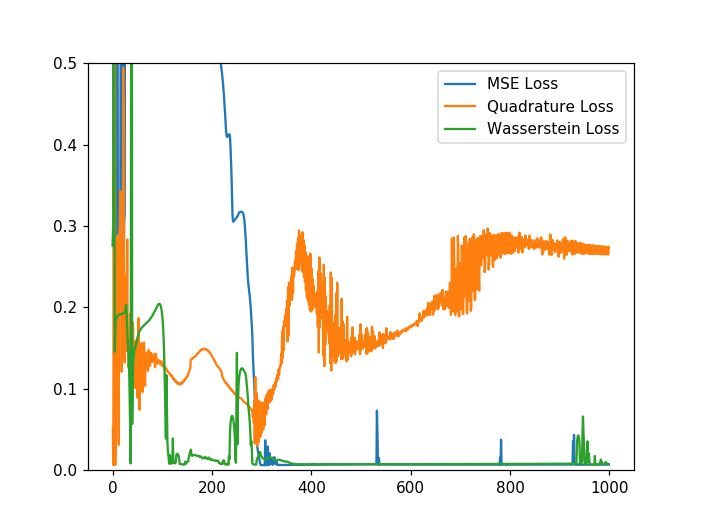

In [6]:
%matplotlib notebook
#Produce plots
folder = '/Users/juanesteban/PhD_PINNs/Results_Simulation/'

fig = plt.figure()
# ax2 = fig.add_subplot(2, 1, 1)
plt.plot(loss_1.numpy(), label='MSE Loss')
plt.plot(loss_2.numpy(), label='Quadrature Loss')
plt.plot(loss_3.numpy(), label='Wasserstein Loss')
plt.legend()
plt.ylim(0,0.5)
#plt.savefig(folder + 'Loss_Wass.png')
plt.show()

<IPython.core.display.Javascript object>


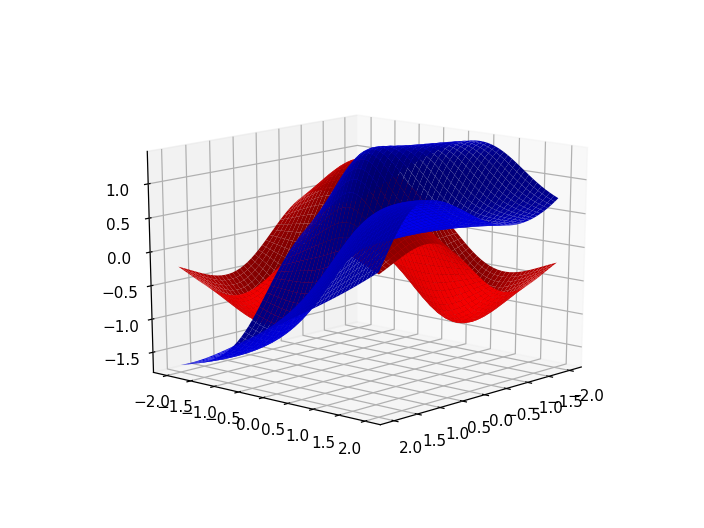

In [7]:
x_t = np.linspace(lb[0], ub[0])
y_t = np.linspace(lb[1], ub[1])
t = 0
X_c = torch.tensor([[[i, j, t] for i in x_t] for j in y_t])
#print(schroedinger1d(X_c, pinn_1(X_c)))
PRED_1 = pinn_1(X_c.float())
PRED_2 = pinn_2(X_c.float())
PRED_3 = pinn_3(X_c.float())
X_m,Y_m = np.meshgrid(x_t,y_t)
fig = plt.figure()
ax = fig.gca(projection='3d')#fig.add_subplot(2, 1, 2, projection='3d')
c1 = ax.plot_surface(X_m, Y_m, PRED_1[:,:,0].detach().numpy(),label='Trained Psi',
                    color='blue')
c3 = ax.plot_surface(X_m, Y_m, Psi(X_m,Y_m,0,1).real,label ='Real Psi',color = 'red')
plt.show()


<IPython.core.display.Javascript object>


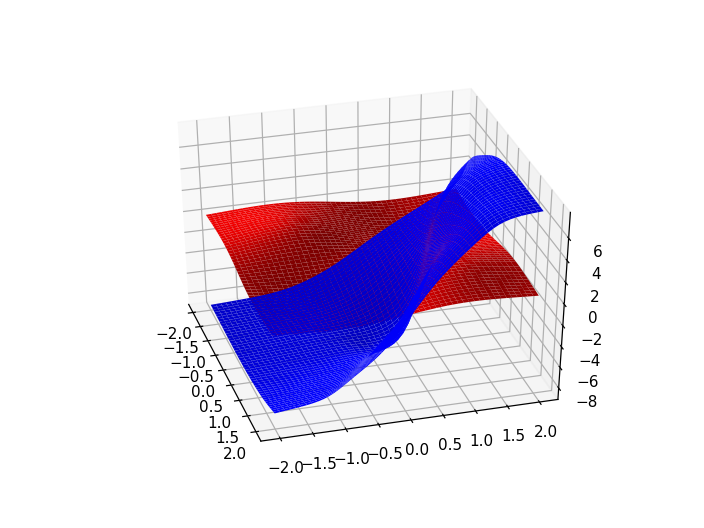

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')#
c2 = ax.plot_surface(X_m, Y_m, PRED_2[:, :, 0].detach().numpy(), label='Trained Psi_wass',
                    color='blue')
c3 = ax.plot_surface(X_m, Y_m, Psi(X_m,Y_m,0,1).real,label ='Real Psi',color = 'red')

plt.show()


<IPython.core.display.Javascript object>


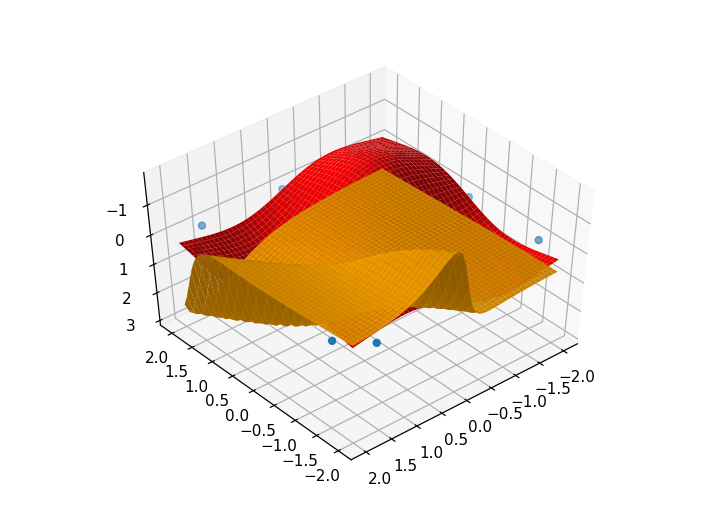

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')#
c2 = ax.plot_surface(X_m, Y_m, PRED_3[:, :, 0].detach().numpy(), label='Trained Psi_wass',
                    color='orange')
c3 = ax.plot_surface(X_m, Y_m, Psi(X_m,Y_m,1,1).real,label ='Real Psi',color = 'red')

plt.show()


<IPython.core.display.Javascript object>


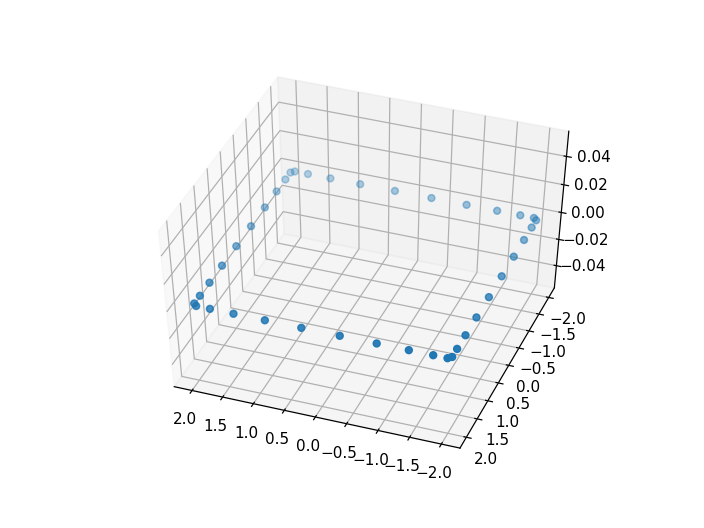

In [24]:
boundary_bdy = [[[lb[0], lb[1], lb[2]], [lb[0], ub[1], ub[2]]], [[ub[0], lb[1], lb[2]], [ub[0], ub[1], ub[2]]],
                        [[lb[0], lb[1], lb[2]], [ub[0], lb[1], ub[2]]],
                        [[lb[0], ub[1], lb[2]], [ub[0], ub[1], ub[2]]]]
boundary_set = np.concatenate([set_gen_1d(10, boundary_bdy[i])[0] for i in range(4)], axis=0)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(boundary_set[:,0],boundary_set[:,1],boundary_set[:,2])
